In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from ltn_imp.automation.knowledge_base import KnowledgeBase


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Train and Evaluate Models

In [3]:
device = torch.device("cpu")

def predict(model, x):
    try:
        model.eval()  # Ensure the model is in evaluation mode
    except:
        ""

    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()

        try:
            probs = model(x)
        except Exception as e:
            x = x.to(torch.device("cpu"))
            probs = torch.tensor(model.predict(x))

        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_metrics(model, data_loader):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

In [4]:
saved_models = []

for file_name in os.listdir("models"):
    if file_name.endswith('.pkl'):
        file_path = os.path.join("models", file_name)
        with open(file_path, 'rb') as file:
            trained_model = pickle.load(file)
            model_class = trained_model.__class__
            model_params = trained_model.get_params()
            new_model = model_class(**model_params)
            saved_models.append(new_model)

In [5]:
def train(model, kb):

    model = kb.predicates["Diabetic"]
    criteria = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    patience = 5
    min_delta = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(50):
        model.train()
        total_loss = 0.0
        num_batches = 0
        
        # Training loop
        for data, labels in kb.loaders[0]:
            optimizer.zero_grad()
            predictions = model(data)
            loss = criteria(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        for data, labels in kb.val_loaders[0]:
            with torch.no_grad():
                predictions = model(data)
                val_loss = criteria(predictions, labels)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches

        # Early stopping logic
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early Stopping at: Epoch {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
            break

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        model.train()
    print()

In [6]:
import torch.nn as nn

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    for layer in linear_layers[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

In [7]:
seeds = [random.randint(0, 2000) for _ in range(30)]

train_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])
test_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])

test_data = pd.read_csv('datasets/pima_indians_imputed.csv', index_col=0).astype(float)
y = test_data.iloc[:, -1]


for seed in seeds:

    x_train, x_test = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=y)
    y_train = x_train.iloc[:, -1]  # Extract labels from the training split
    x_train, x_val = train_test_split(x_train, test_size=0.1, random_state=seed, stratify=y_train)

    x_train.to_csv('datasets/train.csv')
    x_val.to_csv('datasets/val.csv')
    x_test.to_csv('datasets/test.csv')

    x_train, y_train = x_train.iloc[:, :-1], x_train.iloc[:, -1]
    x_test, y_test = x_test.iloc[:, :-1], x_test.iloc[:, -1]

    models = saved_models.copy()

    kb = KnowledgeBase("with_logic.yaml")

    models.append(kb.predicates["Diabetic"])

    X = kb.loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
    Y = kb.loaders[0].loader.dataset.data['Outcome']

    for model in models:
        model_name = model.__class__.__name__

        if model_name == "Sequential":
            model_name = "SKI MLP" 
            
            if "Regular MLP" not in test_df.index:
                test_df.loc["Regular MLP"] = [[], [], [], [], [], []]

        if model_name not in test_df.index:
            test_df.loc[model_name] = [[], [], [], [], [], []] 

        if hasattr(model, "fit"):
            model.fit(X, Y)

        elif model_name == "SKI MLP":
            
            train(model, kb)
            freeze_model(model)

            accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
            test_df.loc["Regular MLP", "Accuracy"].append(accuracy)
            test_df.loc["Regular MLP", "Precision"].append(precision)
            test_df.loc["Regular MLP", "Recall"].append(recall)
            test_df.loc["Regular MLP", "F1 Score"].append(f1)
            test_df.loc["Regular MLP", "Balanced Accuracy"].append(balanced_accuracy)
            test_df.loc["Regular MLP", "MCC"].append(mcc)    
            
            kb.optimize(num_epochs=100, lr=0.0000001, early_stopping=True, patience=5, verbose=False)

        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
        test_df.loc[model_name, "Accuracy"].append(accuracy)
        test_df.loc[model_name, "Precision"].append(precision)
        test_df.loc[model_name, "Recall"].append(recall)
        test_df.loc[model_name, "F1 Score"].append(f1)
        test_df.loc[model_name, "Balanced Accuracy"].append(balanced_accuracy)
        test_df.loc[model_name, "MCC"].append(mcc)        

Using device: cpu
Epoch 1, Train Loss: 0.638339, Val Loss: 0.677670
Epoch 11, Train Loss: 0.454590, Val Loss: 0.548463
Early Stopping at: Epoch 13, Train Loss: 0.461709, Val Loss: 0.555942

Using device: cpu
Epoch 1, Train Loss: 0.676198, Val Loss: 0.705255
Epoch 11, Train Loss: 0.495834, Val Loss: 0.583976
Epoch 21, Train Loss: 0.449740, Val Loss: 0.574647
Early Stopping at: Epoch 23, Train Loss: 0.444758, Val Loss: 0.582924

Using device: cpu
Epoch 1, Train Loss: 0.610269, Val Loss: 0.729267
Epoch 11, Train Loss: 0.485973, Val Loss: 0.648783
Early Stopping at: Epoch 18, Train Loss: 0.462468, Val Loss: 0.648684

Using device: cpu
Epoch 1, Train Loss: 0.696644, Val Loss: 0.682187
Epoch 11, Train Loss: 0.471709, Val Loss: 0.453032
Epoch 21, Train Loss: 0.435298, Val Loss: 0.423212
Early Stopping at: Epoch 25, Train Loss: 0.439481, Val Loss: 0.412087

Using device: cpu
Epoch 1, Train Loss: 0.704605, Val Loss: 0.718405
Epoch 11, Train Loss: 0.516859, Val Loss: 0.493493
Epoch 21, Train Los

In [8]:
def plot_metrics(metrics_df):
    metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]
    plt.figure(figsize=(15, 25))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(6, 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

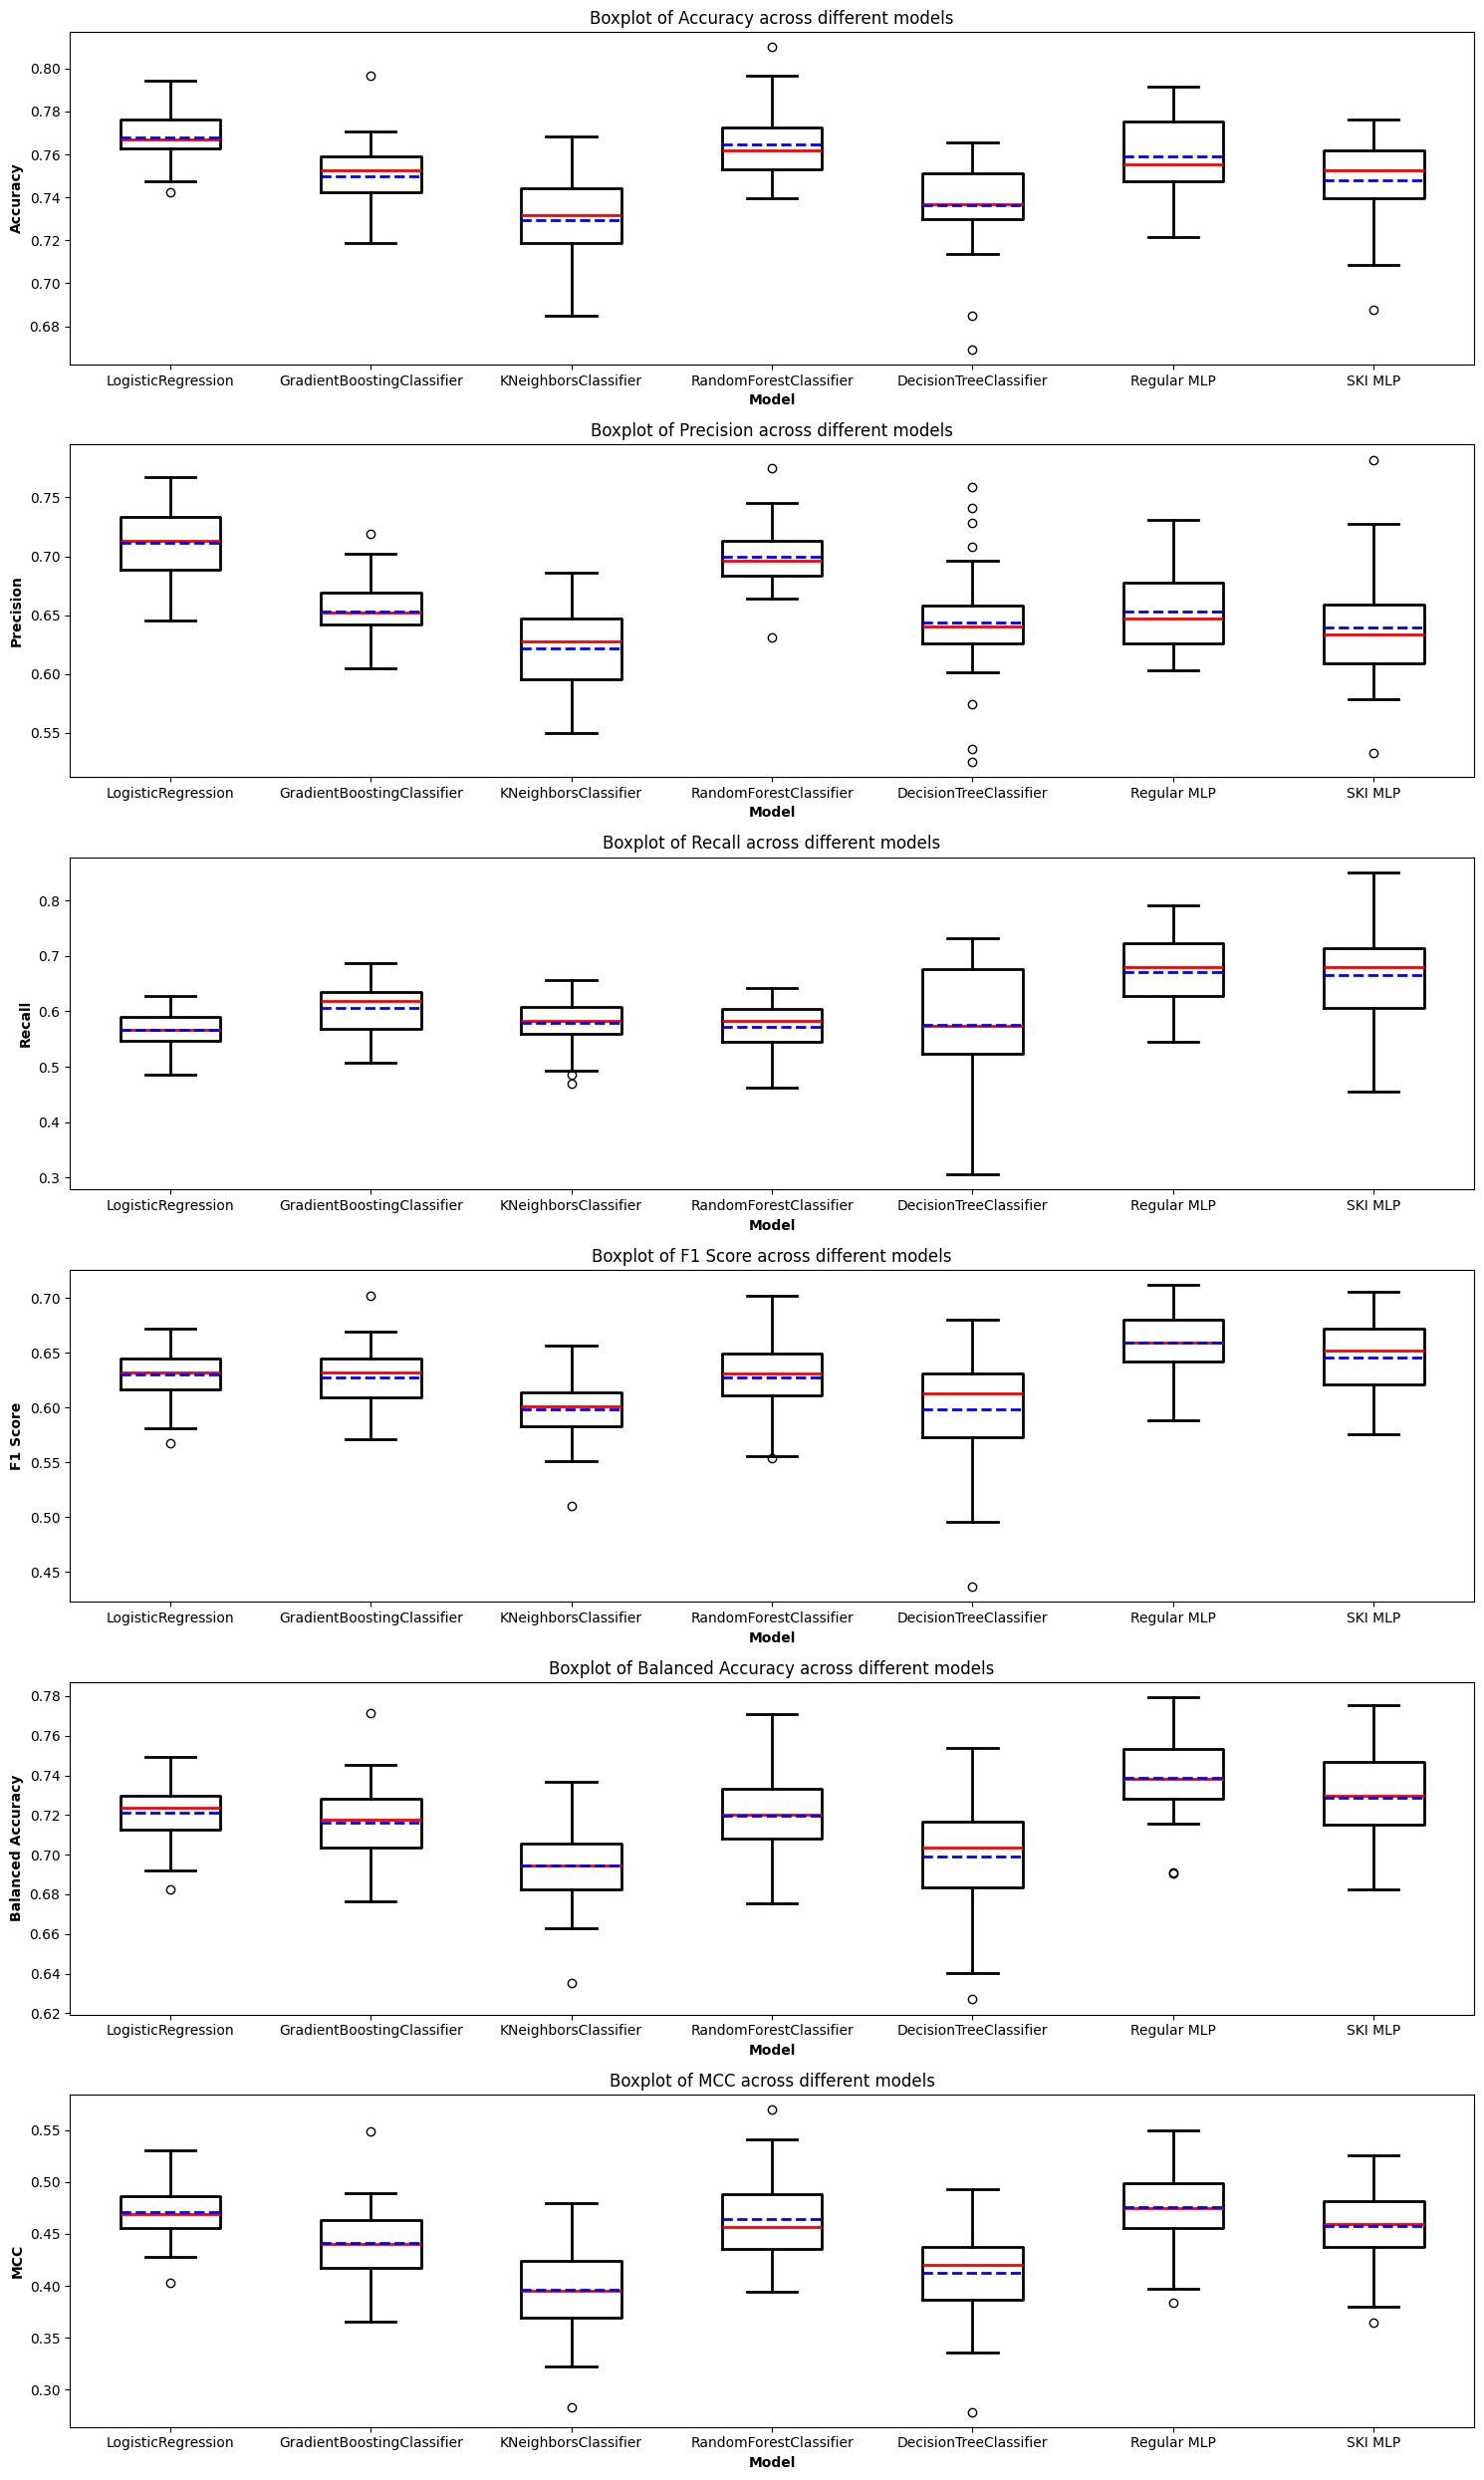

In [9]:
plot_metrics(test_df)

In [10]:
import scipy.stats as stats

def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        mean_scores = metrics_df[metric].apply(np.mean)
        best_model = mean_scores.idxmax()  
        best_models[metric] = best_model

    results = {}
    for metric in metrics_df.columns:
        best_model = best_models[metric]
        best_scores = metrics_df.loc[best_model, metric]
        
        results[metric] = {}
        
        for model_name in metrics_df.index:
            if model_name == best_model:
                continue
            
            comparison_scores = metrics_df.loc[model_name, metric]
            t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
            results[metric][model_name] = p_value 

    significance_level = 0.05
    for metric, comparisons in results.items():
        print(f"\n{metric}:")
        best_model = best_models[metric]
        for model_name, p_value in comparisons.items():
            if p_value < significance_level:
                print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
            else:
                print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")

In [11]:
compare_models(test_df)


Accuracy:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is NOT significantly better than RandomForestClassifier (p = 0.2080)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0.0035)
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)

Precision:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0215)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0.0000)
  LogisticRegression is significantly better than SKI MLP (p

In [12]:
import scipy.stats as stats

def perform_t_tests(metrics_df):

    results = {}

    for metric in metrics_df.columns:
        # Retrieve the scores for SKI MLP and Regular MLP
        ski_mlp_scores = metrics_df.loc['SKI MLP', metric]
        regular_mlp_scores = metrics_df.loc['Regular MLP', metric]
        
        # Perform a paired t-test between SKI MLP and Regular MLP
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        results[metric] = p_value 

    # Significance level for the tests
    significance_level = 0.05

    for metric, p_value in results.items():
        print(f"\n{metric}:")
        if p_value < significance_level:
            print(f"  SKI MLP is significantly better than Regular MLP (p = {p_value:.4f})")
        else:
            print(f"  SKI MLP is NOT significantly better than Regular MLP (p = {p_value:.4f})")

In [13]:
perform_t_tests(test_df)


Accuracy:
  SKI MLP is significantly better than Regular MLP (p = 0.0003)

Precision:
  SKI MLP is significantly better than Regular MLP (p = 0.0302)

Recall:
  SKI MLP is NOT significantly better than Regular MLP (p = 0.6292)

F1 Score:
  SKI MLP is significantly better than Regular MLP (p = 0.0037)

Balanced Accuracy:
  SKI MLP is significantly better than Regular MLP (p = 0.0032)

MCC:
  SKI MLP is significantly better than Regular MLP (p = 0.0008)
